# Order-restricted equality of proportions

In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import matplotlib.pyplot as plt
import numpy as np
import bayesflow as bf
import keras

INFO:bayesflow:Using backend 'jax'

Compared to the previous example, now we will add another model to the
mix, a model that suggests that $\theta_2 > \theta_1$:

### Simulator

We will also amortize over different sample sizes for each group.

In [2]:
def context():
    n = np.random.randint(1000, 10_000, size=2)
    return dict(n = n)

def prior_null():
    theta = np.random.beta(a=1, b=1)
    return dict(theta = np.array([theta, theta]))

def prior_alternative():
    theta = np.random.beta(a=1, b=1, size=2)
    return dict(theta = theta)

def prior_restricted():
    theta = np.random.beta(a=1, b=1, size=2)
    theta = np.sort(theta)

    return dict(theta=theta)

def likelihood(theta, n):
    s = np.random.binomial(n=n, p=theta)
    return dict(s=s)

simulator_null = bf.make_simulator([context, prior_null, likelihood])
simulator_alternative = bf.make_simulator([context, prior_alternative, likelihood])
simulator_restricted = bf.make_simulator([context, prior_restricted, likelihood])
simulator = bf.simulators.ModelComparisonSimulator(
    simulators=[simulator_null, simulator_alternative, simulator_restricted], 
    use_mixed_batches=True)

### Approximator

In [3]:
adapter = (
    bf.Adapter()
    .concatenate(['n', 's'], into="classifier_conditions")
    .drop('theta')
    )

In [4]:
classifier_network = keras.Sequential([
    keras.layers.Dense(32, activation="gelu")
    for _ in range(8)
])
approximator = bf.approximators.ModelComparisonApproximator(
    num_models=3, 
    classifier_network=classifier_network, 
    adapter=adapter)

### Training

In [5]:
epochs = 50
num_batches = 100
batch_size = 512

learning_rate = keras.optimizers.schedules.CosineDecay(5e-4, decay_steps=epochs*num_batches)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
approximator.compile(optimizer=optimizer)

In [ ]:
history = approximator.fit(
    epochs=epochs,
    num_batches=num_batches,
    batch_size=batch_size,
    simulator=simulator,
    adapter=adapter
)

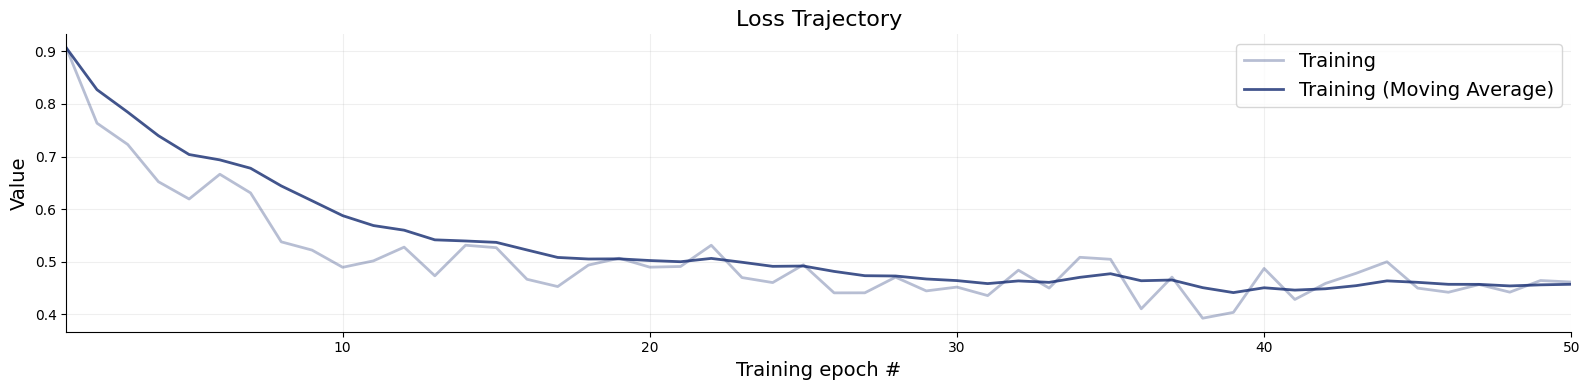

In [7]:
f=bf.diagnostics.plots.loss(history=history)

### Validation

In [8]:
test_data=simulator.sample(5_000)

In [9]:
true_models=test_data["model_indices"]
pred_models=approximator.predict(conditions=test_data)

INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode

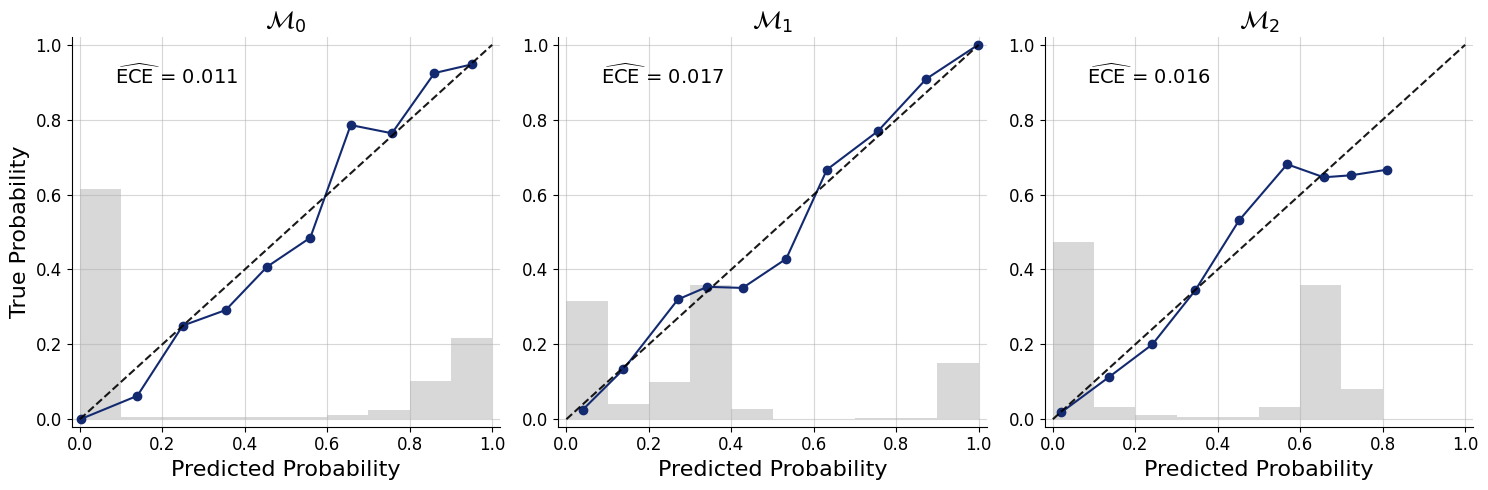

In [10]:
f=bf.diagnostics.plots.mc_calibration(
    pred_models=pred_models,
    true_models=true_models,
    model_names=[r"$\mathcal{M}_0$",r"$\mathcal{M}_1$", r"$\mathcal{M}_2$"],
)

INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode

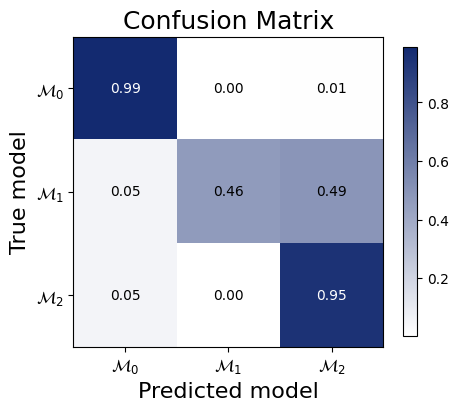

In [11]:
f=bf.diagnostics.plots.mc_confusion_matrix(
    pred_models=pred_models,
    true_models=true_models,
    model_names=[r"$\mathcal{M}_0$",r"$\mathcal{M}_1$", r"$\mathcal{M}_2$"],
    normalize="true"
)

### Inference

In [12]:
inference_data = dict(n = np.array([[5416, 9072]]), s = np.array([[424, 777]]))

In [13]:
pred_models = approximator.predict(conditions=inference_data)[0]
pred_models

array([0.84351516, 0.06271459, 0.0937703 ], dtype=float32)